In [ ]:
from __future__ import annotations

from pathlib import Path
from typing import Tuple, Dict, Any, Callable

import numpy as np
import torch
from numpy.typing import ArrayLike

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

from pyod.models.ecod import ECOD

from usflows import Flow

# ---------------------------------------------------------------------------
# Global configuration
# ---------------------------------------------------------------------------

RANDOM_STATE: int = 42
DATA_DIR: Path = Path("./nf4ad/data/adbench")  # assumes ./data contains the Classical .npz files


# ---------------------------------------------------------------------------
# Dataset resolution & loading (unchanged)
# ---------------------------------------------------------------------------

def resolve_npz_path(dataset_name: str, data_dir: Path = DATA_DIR) -> Path:
    dataset_name = dataset_name.strip()
    data_dir = Path(data_dir)

    if not data_dir.is_dir():
        raise FileNotFoundError(
            f"Data directory {data_dir.resolve()} does not exist. "
            "Make sure you created it and copied the ADBench .npz files into it."
        )

    candidate = data_dir / dataset_name
    if candidate.is_file():
        return candidate

    if not dataset_name.endswith(".npz"):
        candidate_with_ext = data_dir / f"{dataset_name}.npz"
        if candidate_with_ext.is_file():
            return candidate_with_ext

    candidates = []

    if dataset_name.isdigit():
        prefix = f"{dataset_name}_"
        candidates = [p for p in data_dir.glob("*.npz") if p.name.startswith(prefix)]
    else:
        norm = dataset_name.lower()
        for p in data_dir.glob("*.npz"):
            stem = p.stem.lower()
            if stem == norm:
                candidates.append(p)
                continue
            if "_" in stem:
                _, suffix = stem.split("_", 1)
                if suffix == norm:
                    candidates.append(p)

    if not candidates:
        raise FileNotFoundError(
            f"Could not match dataset name '{dataset_name}' to any .npz file in "
            f"{data_dir.resolve()}."
        )

    if len(candidates) > 1:
        names = ", ".join(sorted(p.name for p in candidates))
        raise RuntimeError(
            f"Dataset name '{dataset_name}' is ambiguous; it matches multiple files: "
            f"{names}. Please specify a more precise name."
        )

    return candidates[0]


def load_classical_dataset(
    dataset_name: str,
    data_dir: Path = DATA_DIR,
) -> Tuple[np.ndarray, np.ndarray]:
    npz_path = resolve_npz_path(dataset_name, data_dir)
    npz = np.load(npz_path, allow_pickle=True)

    X = npz["X"]
    y = npz["y"].astype(int)

    print(
        f"Loaded {npz_path.name}: X.shape={X.shape}, "
        f"y.shape={y.shape}, anomaly_ratio={y.mean():.4f}"
    )

    return X, y


# ---------------------------------------------------------------------------
# Metrics (unchanged)
# ---------------------------------------------------------------------------


def evaluate_anomaly_scores(
    y_true: ArrayLike,
    scores: ArrayLike,
) -> Dict[str, float]:
    y_true = np.asarray(y_true).astype(int).ravel()
    scores = np.asarray(scores, dtype=float).ravel()

    if y_true.shape[0] != scores.shape[0]:
        raise ValueError(
            f"y_true and scores must have the same length, "
            f"got {y_true.shape[0]} and {scores.shape[0]}."
        )

    if np.unique(y_true).size < 2:
        raise ValueError(
            "y_true must contain both normal (0) and anomalous (1) labels."
        )

    metrics: Dict[str, float] = {}
    metrics["auc_roc"] = float(roc_auc_score(y_true, scores))
    metrics["auc_pr"] = float(average_precision_score(y_true, scores))

    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    best_idx = int(np.argmax(f1))
    metrics["best_f1"] = float(f1[best_idx])

    if thresholds.size > 0 and best_idx < thresholds.size:
        metrics["best_f1_threshold"] = float(thresholds[best_idx])
    else:
        metrics["best_f1_threshold"] = float("nan")

    return metrics


# ---------------------------------------------------------------------------
# Your method stub (unchanged)
# ---------------------------------------------------------------------------

def create_flow_prior(latent_dim, device: torch.device):
    """Helper to create flow prior with specified latent dimension."""
    from nf4ad.flows import NonUSFlow
    import pyro.distributions as dist
    import torch.nn as nn
    
    base_dist = dist.Normal(
        torch.zeros(latent_dim).to(device),
        torch.ones(latent_dim).to(device)
    )
    
    # Simple MLP conditioner for testing
    class SimpleConditioner(nn.Module):
        def __init__(self, in_dim, out_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 128),
                nn.ReLU(),
                nn.Linear(128, out_dim),
            )
        
        def forward(self, x):
            return self.net(x)
    
    # from U import 
    
    flow = NonUSFlow(
        in_dims=[latent_dim],
        device=device,
        coupling_blocks=3,
        base_distribution=base_dist,
        prior_scale=1.0,
        affine_conjugation=True,
        conditioner_cls=SimpleConditioner,
        conditioner_args={
            'in_dim': latent_dim,
            'out_dim': latent_dim * 2,  # For affine coupling: scale + shift
        },
        nonlinearity=nn.ReLU(),
    )
    
    return flow


def your_method_scores(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
) -> np.ndarray:
    """
    Template wrapper for flow anomaly detection method.

    Implement s.t.:
        1) Fits your model on (X_train, y_train) in the appropriate way
           (for unsupervised methods you may ignore y_train).
        2) Returns a 1D array of anomaly scores for X_test, where higher
           scores mean "more anomalous".

    Returns
    -------
    scores : np.ndarray of shape (n_test,)
        Anomaly scores for X_test.
    """
    # Get number of features
    n_features = X_train.shape[1]
    
    from nf4ad.adbench_wrapper import ADBenchVAEFlowTabular
    
    flow = ADBenchVAEFlowTabular(
        flow_prior=create_flow_prior(n_features, device=torch.device('cuda')),
        n_features=5,
        latent_dim=n_features,
    )
    vaeflow.fit(X_train, y_train)
    return vaeflow.predict_score(X_test)


# ---------------------------------------------------------------------------
# PyOD baseline (ECOD)
# ---------------------------------------------------------------------------

def run_pyod_ecod_baseline(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
) -> np.ndarray:
    """
    Run ECOD (Empirical Cumulative Distribution based Outlier Detection)
    from PyOD as an unsupervised baseline.

    This is one of the unsupervised methods ADBench includes via PyOD,
    but here we call it directly through PyOD's modern API.
    """
    clf = ECOD()          # y is ignored in unsupervised PyOD models
    clf.fit(X_train)      # fit on train set
    scores = clf.decision_function(X_test)  # higher = more anomalous

    return np.asarray(scores, dtype=float).ravel()


# ---------------------------------------------------------------------------
# High-level helper to run everything on one dataset (slightly tweaked)
# ---------------------------------------------------------------------------

def run_single_dataset_example(
    dataset_name: str = "cardio",
    data_dir: Path = DATA_DIR,
    use_baseline: bool = True,
    method_fn: Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray] | None = None,
) -> Dict[str, Any]:
    """
    Pipeline:
      - load dataset from .npz
      - split into train/test
      - standardize features
      - run either ECOD baseline or your custom method
      - compute metrics
    """
    X, y = load_classical_dataset(dataset_name, data_dir=data_dir)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=RANDOM_STATE,
        stratify=y,
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if use_baseline:
        scores = run_pyod_ecod_baseline(X_train_scaled, y_train, X_test_scaled)
        model_used = "PyOD-ECOD"
    else:
        if method_fn is None:
            raise ValueError(
                "use_baseline=False but no method_fn was provided. "
                "Pass your own method wrapper, e.g. method_fn=your_method_scores."
            )
        scores = method_fn(X_train_scaled, y_train, X_test_scaled)
        model_used = getattr(method_fn, "__name__", "custom_method")

    metrics = evaluate_anomaly_scores(y_test, scores)

    result: Dict[str, Any] = {
        "dataset": dataset_name,
        "n_train": int(X_train.shape[0]),
        "n_test": int(X_test.shape[0]),
        "model": model_used,
        "metrics": metrics,
    }

    print(
        f"\nResults on dataset='{dataset_name}' using model='{model_used}':\n"
        f"  AUC-ROC : {metrics['auc_roc']:.4f}\n"
        f"  AUC-PR  : {metrics['auc_pr']:.4f}\n"
        f"  best F1 : {metrics['best_f1']:.4f} "
        f"(at score threshold ≈ {metrics['best_f1_threshold']:.4f})"
    )

    return result


# ---------------------------------------------------------------------------
# Example call
# ---------------------------------------------------------------------------

# Run example
example_result = run_single_dataset_example(
    dataset_name="cardio",
    use_baseline=False,
    method_fn=your_method_scores,
)
example_result


ModuleNotFoundError: No module named 'pyod'

In [1]:
# Run example
example_result = run_single_dataset_example(
    dataset_name="cardio",
    use_baseline=False,
    method_fn=your_method_scores,
)
example_result

NameError: name 'run_single_dataset_example' is not defined

# Flow Model Benchmarking on ADBench

This notebook demonstrates how to use the comprehensive benchmarking system for Flow models on ADBench datasets.

In [1]:
from nf4ad.adbench_benchmark import (
    ADBenchBenchmark,
    BenchmarkConfig,
    FlowConfig,
    ADBENCH_CLASSICAL_DATASETS,
)
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

/home/faried/.cache/pypoetry/virtualenvs/nf4ad-ewA-z3hl-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Quick Single Dataset Test

In [2]:
# Configure benchmark
config = BenchmarkConfig(
    data_dir=Path("./nf4ad/data/adbench"),
    output_dir=Path("./results/adbench"),
    device="cpu",
    verbose=True,
)

# Configure flow model
flow_config = FlowConfig(
    coupling_blocks=8,
    hidden_dim=128,
    lr=1e-3,
    batch_size=64,
    epochs=10000,
    patience=3,
    clamp=1.5
)

# Run on single dataset
benchmark = ADBenchBenchmark(config)
results = benchmark.run_on_datasets(
    datasets=["6_cardio"],
    flow_config=flow_config,
)

# Display results
benchmark.results_to_dataframe()


Running experiment on 6_cardio
Flow type: nonusflow
Dataset: 6_cardio
Features: 21
Train: 915 samples (88 anomalies)
Test: 916 samples (88 anomalies)
Training Flow model on 915 samples...
Input shape: torch.Size([915, 21])
Device: cpu
Epoch 10/10000, Loss: 128055961472397040.0000
Epoch 10/10000, Loss: 128055961472397040.0000
Epoch 20/10000, Loss: 18801762687394340.0000
Epoch 20/10000, Loss: 18801762687394340.0000
Early stopping at epoch 26/10000
Restored best model with loss: 12791461760624230.0000
Training completed. Final loss: 15241944542356002.0000

Results:
  ROC-AUC: 0.6652
  PR-AUC:  0.1883
  Best F1: 0.2540
  Training time: 9.23s
  Epochs: 26
Early stopping at epoch 26/10000
Restored best model with loss: 12791461760624230.0000
Training completed. Final loss: 15241944542356002.0000

Results:
  ROC-AUC: 0.6652
  PR-AUC:  0.1883
  Best F1: 0.2540
  Training time: 9.23s
  Epochs: 26


,dataset,n_features,n_train,n_test,n_anomalies_test,roc_auc,pr_auc,best_f1,training_time,inference_time,n_epochs,config_coupling_blocks,config_hidden_dim,config_lr,config_batch_size,config_epochs,config_patience,config_min_delta,config_gradient_clip,config_clamp,config_lu_transform,config_householder,config_affine_conjugation,config_prior_scale,config_masktype,config_flow_type
0,6_cardio,21,915,916,88,0.665171,0.188348,0.253968,9.22847,0.013763,26,8,128,0.001,64,10000,3,0.0001,None,1.5,1,0,True,1.0,checkerboard,nonusflow


## 2. Multiple Datasets Benchmark

In [ ]:
# Select datasets to test
test_datasets = [
    "6_cardio",
    "2_annthyroid",
    "38_thyroid",
    "4_breastw",
    "18_Ionosphere",
]

# Run benchmark
benchmark = ADBenchBenchmark(config)
results = benchmark.run_on_datasets(
    datasets=test_datasets,
    flow_config=flow_config,
)

# Display results
df = benchmark.results_to_dataframe()
print(df[['dataset', 'roc_auc', 'pr_auc', 'best_f1', 'training_time', 'n_epochs']])

## 3. Hyperparameter Search

In [7]:
# Define parameter grid
param_grid = {
    'coupling_blocks': [4, 8, 12],
    'hidden_dim': [64, 128, 256],
    'lr': [1e-4, 1e-3, 1e-2],
    'batch_size': [32, 64],
    'epochs': [10000],
    'patience': [3],
    "clamp": [1.5]
}

# Select datasets for tuning
tune_datasets = ["6_cardio", "14_glass", "25_musk", "3_backdoor"]

# Run hyperparameter search
benchmark = ADBenchBenchmark(config)
results_df = benchmark.hyperparameter_search(
    datasets=tune_datasets,
    param_grid=param_grid,
    n_trials=10,  # Try 10 random configurations
)

# Show top configurations
print("Top 10 configurations by ROC-AUC:")
top_configs = results_df.nlargest(10, 'roc_auc')
print(top_configs[[
    'dataset', 'roc_auc', 'pr_auc', 'best_f1',
    'config_coupling_blocks', 'config_hidden_dim', 'config_lr', 'config_batch_size'
]])


Starting Hyperparameter Search
Datasets: 4
Parameter grid size: 54
Running 10 configurations

[1/10] Configuration: {'coupling_blocks': 8, 'hidden_dim': 128, 'lr': 0.001, 'batch_size': 64, 'epochs': 10000, 'patience': 3, 'min_delta': 0.0001, 'gradient_clip': None, 'clamp': 1.5, 'lu_transform': 1, 'householder': 0, 'affine_conjugation': True, 'prior_scale': 1.0, 'masktype': 'checkerboard', 'flow_type': 'nonusflow'}

Running experiment on 6_cardio
Flow type: nonusflow
Dataset: 6_cardio
Features: 21
Train: 915 samples (88 anomalies)
Test: 916 samples (88 anomalies)
Training Flow model on 915 samples...
Input shape: torch.Size([915, 21])
Device: cpu
Epoch 10/10000, Loss: 6435275207920845.0000
Epoch 10/10000, Loss: 6435275207920845.0000
Epoch 20/10000, Loss: 1147595578461388.7500
Epoch 20/10000, Loss: 1147595578461388.7500
Early stopping at epoch 29/10000
Restored best model with loss: 383538245262813.8750
Training completed. Final loss: 981359704775065.6250

Results:
  ROC-AUC: 0.6741
  P

KeyboardInterrupt: 

## 4. Analyze Results by Dataset

In [ ]:
# Group by dataset and show statistics
summary = results_df.groupby('dataset').agg({
    'roc_auc': ['mean', 'std', 'max'],
    'pr_auc': ['mean', 'std', 'max'],
    'best_f1': ['mean', 'std', 'max'],
    'training_time': 'mean',
    'n_epochs': 'mean',
}).round(4)

print(summary)

## 5. Visualize Results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot ROC-AUC by dataset
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='dataset', y='roc_auc')
plt.xticks(rotation=45)
plt.title('ROC-AUC Distribution by Dataset')
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.show()

# Plot hyperparameter effects
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Coupling blocks effect
sns.boxplot(data=results_df, x='config_coupling_blocks', y='roc_auc', ax=axes[0, 0])
axes[0, 0].set_title('Effect of Coupling Blocks')

# Hidden dim effect
sns.boxplot(data=results_df, x='config_hidden_dim', y='roc_auc', ax=axes[0, 1])
axes[0, 1].set_title('Effect of Hidden Dimension')

# Learning rate effect
sns.boxplot(data=results_df, x='config_lr', y='roc_auc', ax=axes[1, 0])
axes[1, 0].set_title('Effect of Learning Rate')

# Batch size effect
sns.boxplot(data=results_df, x='config_batch_size', y='roc_auc', ax=axes[1, 1])
axes[1, 1].set_title('Effect of Batch Size')

plt.tight_layout()
plt.show()

## 6. Training Curves Analysis

In [ ]:
# Plot training curves for best performing configurations
best_result = benchmark.results[0]  # Get first result

plt.figure(figsize=(10, 6))
plt.plot(best_result.training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Curve - {best_result.dataset}')
plt.grid(True)
plt.show()

print(f"Dataset: {best_result.dataset}")
print(f"Final ROC-AUC: {best_result.metrics['roc_auc']:.4f}")
print(f"Training time: {best_result.training_time:.2f}s")
print(f"Epochs trained: {best_result.n_epochs_trained}")

## 7. Save and Load Results

In [ ]:
# Save results
benchmark.save_results("my_experiment")

# Results are saved as:
# - JSON (full details with training curves)
# - CSV (summary table)

# Load and analyze later
import json

with open(config.output_dir / "my_experiment.json") as f:
    loaded_results = json.load(f)

print(f"Loaded {len(loaded_results)} results")

## 8. Using USFlow Model

In [3]:
# Test with USFlow instead of NonUSFlow
config = BenchmarkConfig(
    data_dir=Path("./nf4ad/data/adbench"),
    output_dir=Path("./results/adbench/usflow"),
    device="cpu",
    verbose=True,
)

# Configure USFlow model
usflow_config = FlowConfig(
    flow_type="usflow",  # Switch to USFlow
    coupling_blocks=8,
    hidden_dim=128,
    lr=1e-3,
    batch_size=64,
    epochs=10000,
    patience=5,
    lu_transform=1,
    householder=0,
    affine_conjugation=True,
    prior_scale=1.0,
    masktype="checkerboard",
)

# Run on single dataset
benchmark = ADBenchBenchmark(config)
results = benchmark.run_on_datasets(
    datasets=["6_cardio"],
    flow_config=usflow_config,
)

# Display results
benchmark.results_to_dataframe()


Running experiment on 6_cardio
Flow type: usflow
Dataset: 6_cardio
Features: 21
Train: 915 samples (88 anomalies)
Test: 916 samples (88 anomalies)
Training Flow model on 915 samples...
Input shape: torch.Size([915, 21])
Device: cpu
Epoch 10/10000, Loss: 291.7187
Epoch 10/10000, Loss: 291.7187
Epoch 20/10000, Loss: 146.2848
Epoch 20/10000, Loss: 146.2848
Early stopping at epoch 29/10000
Restored best model with loss: 111.2384
Training completed. Final loss: 184.1804

Results:
  ROC-AUC: 0.7651
  PR-AUC:  0.3017
  Best F1: 0.3362
  Training time: 5.86s
  Epochs: 29
Early stopping at epoch 29/10000
Restored best model with loss: 111.2384
Training completed. Final loss: 184.1804

Results:
  ROC-AUC: 0.7651
  PR-AUC:  0.3017
  Best F1: 0.3362
  Training time: 5.86s
  Epochs: 29


,dataset,n_features,n_train,n_test,n_anomalies_test,roc_auc,pr_auc,best_f1,training_time,inference_time,n_epochs,config_coupling_blocks,config_hidden_dim,config_lr,config_batch_size,config_epochs,config_patience,config_min_delta,config_gradient_clip,config_clamp,config_lu_transform,config_householder,config_affine_conjugation,config_prior_scale,config_masktype,config_flow_type
0,6_cardio,21,915,916,88,0.765124,0.301697,0.336207,5.862994,0.006722,29,8,128,0.001,64,10000,5,0.0001,None,5.0,1,0,True,1.0,checkerboard,usflow


## 9. Compare NonUSFlow vs USFlow


Running experiment on 6_cardio
Flow type: nonusflow
Dataset: 6_cardio
Features: 21
Train: 915 samples (88 anomalies)
Test: 916 samples (88 anomalies)
Training Flow model on 915 samples...
Input shape: torch.Size([915, 21])
Device: cpu
Epoch 10/30, Loss: 2006835244424669.7500
Epoch 10/30, Loss: 2006835244424669.7500
Epoch 20/30, Loss: 1646181041255219.2500
Epoch 20/30, Loss: 1646181041255219.2500
Early stopping at epoch 22/30
Restored best model with loss: 883997002782037.3750
Training completed. Final loss: 933762609883818.6250

Results:
  ROC-AUC: 0.7062
  PR-AUC:  0.2215
  Best F1: 0.3284
  Training time: 8.07s
  Epochs: 22

Running experiment on 2_annthyroid
Flow type: nonusflow
Dataset: 2_annthyroid
Features: 6
Train: 3600 samples (267 anomalies)
Test: 3600 samples (267 anomalies)
Training Flow model on 3600 samples...
Input shape: torch.Size([3600, 6])
Device: cpu
Early stopping at epoch 22/30
Restored best model with loss: 883997002782037.3750
Training completed. Final loss: 933

/tmp/ipykernel_101233/3548885326.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_101233/3548885326.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_101233/3548885326.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


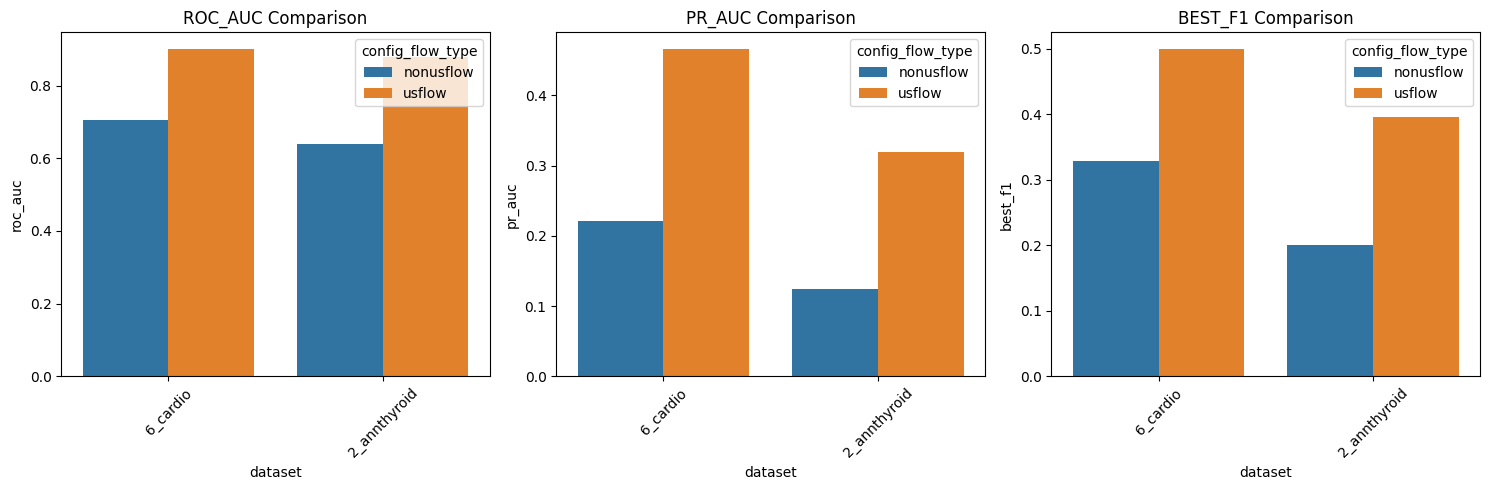


Comparison Summary:
                               roc_auc  pr_auc  best_f1  training_time
dataset      config_flow_type                                         
2_annthyroid nonusflow          0.6388  0.1239   0.2007        35.8763
             usflow             0.8787  0.3193   0.3954        20.6276
6_cardio     nonusflow          0.7062  0.2215   0.3284         8.0672
             usflow             0.9015  0.4664   0.5000         5.9646


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run both flow types on same datasets
test_datasets = ["6_cardio", "2_annthyroid"]
benchmark = ADBenchBenchmark(config)

for flow_type in ["nonusflow", "usflow"]:
    flow_config = FlowConfig(
        flow_type=flow_type,
        coupling_blocks=8,
        hidden_dim=128,
        lr=1e-3,
        batch_size=64,
        epochs=30,
        patience=5,
    )
    
    if flow_type == "usflow":
        flow_config.lu_transform = 1
        flow_config.householder = 0
        flow_config.masktype = "checkerboard"
    else:
        flow_config.lu_transform = 1
        flow_config.householder = 0
        flow_config.clamp = 1.5
    
    benchmark.run_on_datasets(
        datasets=test_datasets,
        flow_config=flow_config,
    )

# Compare results
df = benchmark.results_to_dataframe()

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(['roc_auc', 'pr_auc', 'best_f1']):
    sns.barplot(data=df, x='dataset', y=metric, hue='config_flow_type', ax=axes[i])
    axes[i].set_title(f'{metric.upper()} Comparison')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print summary
comparison = df.groupby(['dataset', 'config_flow_type']).agg({
    'roc_auc': 'mean',
    'pr_auc': 'mean',
    'best_f1': 'mean',
    'training_time': 'mean',
}).round(4)
print("\nComparison Summary:")
print(comparison)

## 10. USFlow Hyperparameter Search

In [ ]:
# USFlow-specific hyperparameter grid
usflow_param_grid = {
    'flow_type': ['usflow'],
    'coupling_blocks': [4, 8],
    'hidden_dim': [64, 128],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'lu_transform': [1],
    'affine_conjugation': [True],

    'epochs': [50],
    'patience': [5],
}

# Run search
tune_datasets = ["6_cardio"]
benchmark = ADBenchBenchmark(config)
results_df = benchmark.hyperparameter_search(
    datasets=tune_datasets,
    param_grid=usflow_param_grid,
    n_trials=8,
)

# Show best configurations
print("Top 5 USFlow configurations:")
top = results_df.nlargest(5, 'roc_auc')
print(top[[
    'roc_auc', 'pr_auc', 'training_time',
    'config_lu_transform', 'config_householder', 
    'config_masktype', 'config_affine_conjugation'
]])

In [9]:
# Configure USFlow model
usflow_config = FlowConfig(
    flow_type="usflow",  # Switch to USFlow
    coupling_blocks=8,
    hidden_dim=128,
    lr=1e-3,
    batch_size=64,
    epochs=10000,
    patience=5,
    lu_transform=1,
    householder=0,
    affine_conjugation=True,
    prior_scale=1.0,
    masktype="checkerboard",
)

# Select datasets to test
test_datasets = [
    "6_cardio",
    "2_annthyroid",
    "38_thyroid",
    "4_breastw",
    "18_Ionosphere",
]
test_datasets = ADBENCH_CLASSICAL_DATASETS

# Run benchmark
benchmark = ADBenchBenchmark(config)
results = benchmark.run_on_datasets(
    datasets=test_datasets,
    flow_config=usflow_config,
)

# Display results
df = benchmark.results_to_dataframe()
print(df[['dataset', 'roc_auc', 'pr_auc', 'best_f1', 'training_time', 'n_epochs']])


Running experiment on 1_ALOI
Flow type: usflow
Dataset: 1_ALOI
Features: 27
Train: 24767 samples (754 anomalies)
Test: 24767 samples (754 anomalies)
Training Flow model on 24767 samples...
Input shape: torch.Size([24767, 27])
Device: cpu
Epoch 10/10000, Loss: 220.4250
Epoch 20/10000, Loss: 60.8255
Early stopping at epoch 29/10000
Restored best model with loss: 32.0792
Training completed. Final loss: 39.1629

Results:
  ROC-AUC: 0.5571
  PR-AUC:  0.0438
  Best F1: 0.0840
  Training time: 158.63s
  Epochs: 29

Running experiment on 2_annthyroid
Flow type: usflow
Dataset: 2_annthyroid
Features: 6
Train: 3600 samples (267 anomalies)
Test: 3600 samples (267 anomalies)
Training Flow model on 3600 samples...
Input shape: torch.Size([3600, 6])
Device: cpu
Epoch 10/10000, Loss: 129.2617
Epoch 20/10000, Loss: 63.2082
Early stopping at epoch 28/10000
Restored best model with loss: 43.6494
Training completed. Final loss: 52.6622

Results:
  ROC-AUC: 0.7614
  PR-AUC:  0.2993
  Best F1: 0.3615
  Tr

## 11. Export Results to CSV

In [ ]:
# Save the complete benchmark results to CSV
output_file = config.output_dir / "usflow_adbench_complete_results.csv"
df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

# Create a summary with key metrics
summary_df = df[[
    'dataset', 'n_features', 'n_train', 'n_test',
    'n_anomalies_test', 'roc_auc', 'pr_auc', 'best_f1',
    'training_time', 'n_epochs'
]].copy()

summary_file = config.output_dir / "usflow_adbench_summary.csv"
summary_df.to_csv(summary_file, index=False)
print(f"Summary saved to: {summary_file}")

# Display basic statistics
print("\n" + "="*60)
print("Benchmark Statistics")
print("="*60)
print(f"Total datasets: {len(df)}")
print(f"Average ROC-AUC: {df['roc_auc'].mean():.4f} ± {df['roc_auc'].std():.4f}")
print(f"Average PR-AUC: {df['pr_auc'].mean():.4f} ± {df['pr_auc'].std():.4f}")
print(f"Average Best F1: {df['best_f1'].mean():.4f} ± {df['best_f1'].std():.4f}")
print(f"Total training time: {df['training_time'].sum():.2f}s ({df['training_time'].sum()/3600:.2f}h)")
print(f"Average epochs: {df['n_epochs'].mean():.1f}")

# Top performing datasets
print("\nTop 10 datasets by ROC-AUC:")
print(df.nlargest(10, 'roc_auc')[['dataset', 'roc_auc', 'pr_auc', 'best_f1']])

# Worst performing datasets
print("\nBottom 10 datasets by ROC-AUC:")
print(df.nsmallest(10, 'roc_auc')[['dataset', 'roc_auc', 'pr_auc', 'best_f1']])

## 12. Visualize Complete Results

NameError: name 'config' is not defined

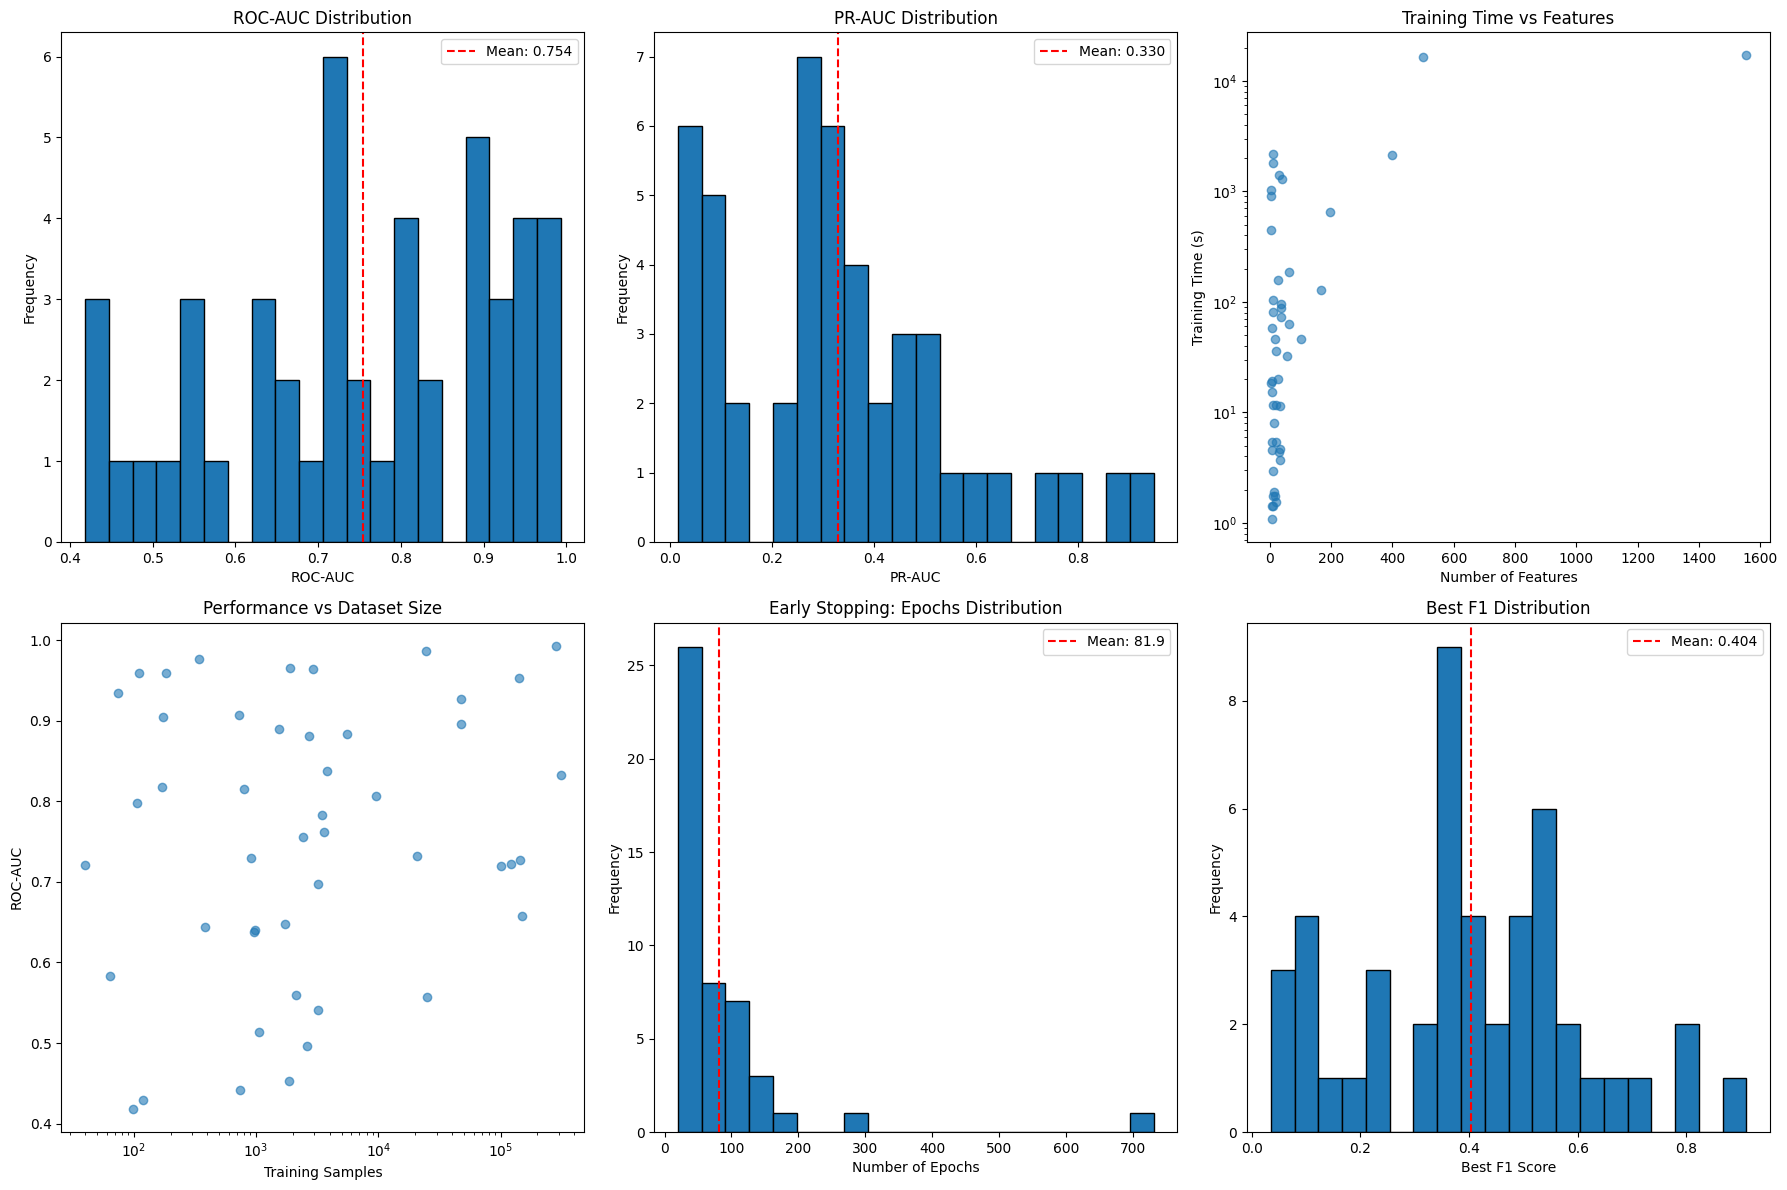

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

path = "/home/faried/Projects/nf4ad/results"
df = pd.read_csv(path + "/usflow_adbench_benchmark_results.csv")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC-AUC distribution
axes[0, 0].hist(df['roc_auc'], bins=20, edgecolor='black')
axes[0, 0].axvline(df['roc_auc'].mean(), color='red', linestyle='--', label=f'Mean: {df["roc_auc"].mean():.3f}')
axes[0, 0].set_xlabel('ROC-AUC')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('ROC-AUC Distribution')
axes[0, 0].legend()

# 2. PR-AUC distribution
axes[0, 1].hist(df['pr_auc'], bins=20, edgecolor='black')
axes[0, 1].axvline(df['pr_auc'].mean(), color='red', linestyle='--', label=f'Mean: {df["pr_auc"].mean():.3f}')
axes[0, 1].set_xlabel('PR-AUC')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('PR-AUC Distribution')
axes[0, 1].legend()

# 3. Training time vs n_features
axes[0, 2].scatter(df['n_features'], df['training_time'], alpha=0.6)
axes[0, 2].set_xlabel('Number of Features')
axes[0, 2].set_ylabel('Training Time (s)')
axes[0, 2].set_title('Training Time vs Features')
axes[0, 2].set_yscale('log')

# 4. ROC-AUC vs dataset size
axes[1, 0].scatter(df['n_train'], df['roc_auc'], alpha=0.6)
axes[1, 0].set_xlabel('Training Samples')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_title('Performance vs Dataset Size')
axes[1, 0].set_xscale('log')

# 5. Epochs distribution
axes[1, 1].hist(df['n_epochs'], bins=20, edgecolor='black')
axes[1, 1].axvline(df['n_epochs'].mean(), color='red', linestyle='--', label=f'Mean: {df["n_epochs"].mean():.1f}')
axes[1, 1].set_xlabel('Number of Epochs')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Early Stopping: Epochs Distribution')
axes[1, 1].legend()

# 6. Best F1 distribution
axes[1, 2].hist(df['best_f1'], bins=20, edgecolor='black')
axes[1, 2].axvline(df['best_f1'].mean(), color='red', linestyle='--', label=f'Mean: {df["best_f1"].mean():.3f}')
axes[1, 2].set_xlabel('Best F1 Score')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Best F1 Distribution')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(path + '/usflow_benchmark_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved!")

## 13. Box Plot Analysis - Performance Metrics

/tmp/ipykernel_10819/760585576.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=metrics_df, x='Metric', y='Score', ax=ax, palette='Set2')


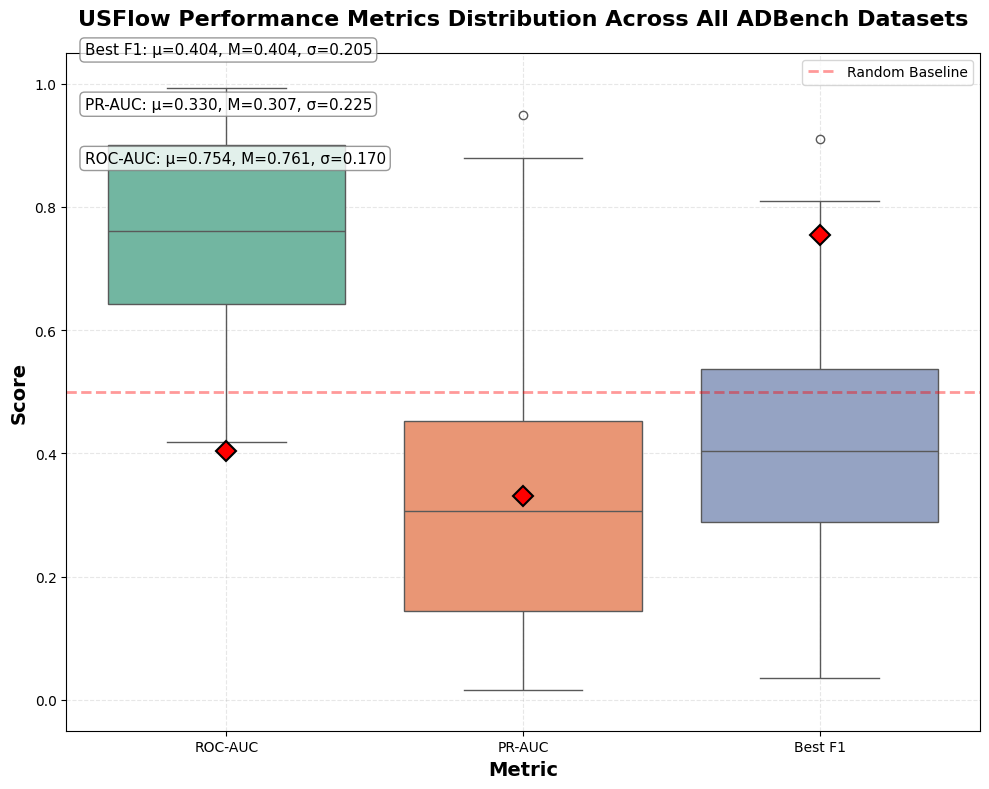


Performance Metrics Statistics Across All 47 ADBench Datasets

Detailed Statistics:
       roc_auc   pr_auc  best_f1
count  47.0000  47.0000  47.0000
mean    0.7544   0.3300   0.4037
std     0.1701   0.2251   0.2050
min     0.4182   0.0156   0.0352
25%     0.6420   0.1450   0.2887
50%     0.7614   0.3066   0.4038
75%     0.9004   0.4524   0.5361
max     0.9932   0.9488   0.9105

--------------------------------------------------------------------------------
Summary:
ROC-AUC  : 0.7544 ± 0.1701  (median: 0.7614)
PR-AUC   : 0.3300 ± 0.2251  (median: 0.3066)
Best F1  : 0.4037 ± 0.2050  (median: 0.4038)

--------------------------------------------------------------------------------
Performance Distribution:
ROC-AUC > 0.9 (Excellent): 12 datasets (25.5%)
ROC-AUC > 0.8 (Good):      21 datasets (44.7%)
ROC-AUC > 0.7 (Fair):      31 datasets (66.0%)
ROC-AUC < 0.5 (Worse than random): 5 datasets



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

path = "/home/faried/Projects/nf4ad/results"
df = pd.read_csv(path + "/usflow_adbench_benchmark_results.csv")

# Create a single comprehensive box plot figure
fig, ax = plt.subplots(figsize=(10, 8))

# Prepare data for box plot
metrics_df = df[['roc_auc', 'pr_auc', 'best_f1']].melt(var_name='Metric', value_name='Score')
metrics_df['Metric'] = metrics_df['Metric'].map({
    'roc_auc': 'ROC-AUC',
    'pr_auc': 'PR-AUC',
    'best_f1': 'Best F1'
})

# Create box plot
box_plot = sns.boxplot(data=metrics_df, x='Metric', y='Score', ax=ax, palette='Set2')

# Customize plot
ax.set_title('USFlow Performance Metrics Distribution Across All ADBench Datasets', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(-0.05, 1.05)

# Add horizontal line at 0.5 (random baseline for ROC-AUC)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.4, linewidth=2, label='Random Baseline')
ax.legend(fontsize=10)

# Add mean markers
means = metrics_df.groupby('Metric')['Score'].mean()
positions = range(len(means))
ax.plot(positions, means.values, 'D', color='red', markersize=10, 
        label='Mean', markeredgecolor='black', markeredgewidth=1.5)

# Add text annotations for statistics
for i, (metric, group) in enumerate(metrics_df.groupby('Metric')):
    mean_val = group['Score'].mean()
    median_val = group['Score'].median()
    std_val = group['Score'].std()
    
    # Position text above the box plot
    y_pos = ax.get_ylim()[1] * 0.95 - (i * 0.08)
    ax.text(0.02, y_pos, 
            f'{metric}: μ={mean_val:.3f}, M={median_val:.3f}, σ={std_val:.3f}',
            transform=ax.transAxes,
            fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.savefig(path + '/usflow_benchmark_metrics_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("Performance Metrics Statistics Across All 47 ADBench Datasets")
print("="*80)
print("\nDetailed Statistics:")
print(df[['roc_auc', 'pr_auc', 'best_f1']].describe().round(4))

print("\n" + "-"*80)
print("Summary:")
print(f"ROC-AUC  : {df['roc_auc'].mean():.4f} ± {df['roc_auc'].std():.4f}  (median: {df['roc_auc'].median():.4f})")
print(f"PR-AUC   : {df['pr_auc'].mean():.4f} ± {df['pr_auc'].std():.4f}  (median: {df['pr_auc'].median():.4f})")
print(f"Best F1  : {df['best_f1'].mean():.4f} ± {df['best_f1'].std():.4f}  (median: {df['best_f1'].median():.4f})")

print("\n" + "-"*80)
print("Performance Distribution:")
print(f"ROC-AUC > 0.9 (Excellent): {(df['roc_auc'] >= 0.9).sum()} datasets ({(df['roc_auc'] >= 0.9).sum()/len(df)*100:.1f}%)")
print(f"ROC-AUC > 0.8 (Good):      {(df['roc_auc'] >= 0.8).sum()} datasets ({(df['roc_auc'] >= 0.8).sum()/len(df)*100:.1f}%)")
print(f"ROC-AUC > 0.7 (Fair):      {(df['roc_auc'] >= 0.7).sum()} datasets ({(df['roc_auc'] >= 0.7).sum()/len(df)*100:.1f}%)")
print(f"ROC-AUC < 0.5 (Worse than random): {(df['roc_auc'] < 0.5).sum()} datasets")

print("\n" + "="*80)

## 15. Training Efficiency Analysis

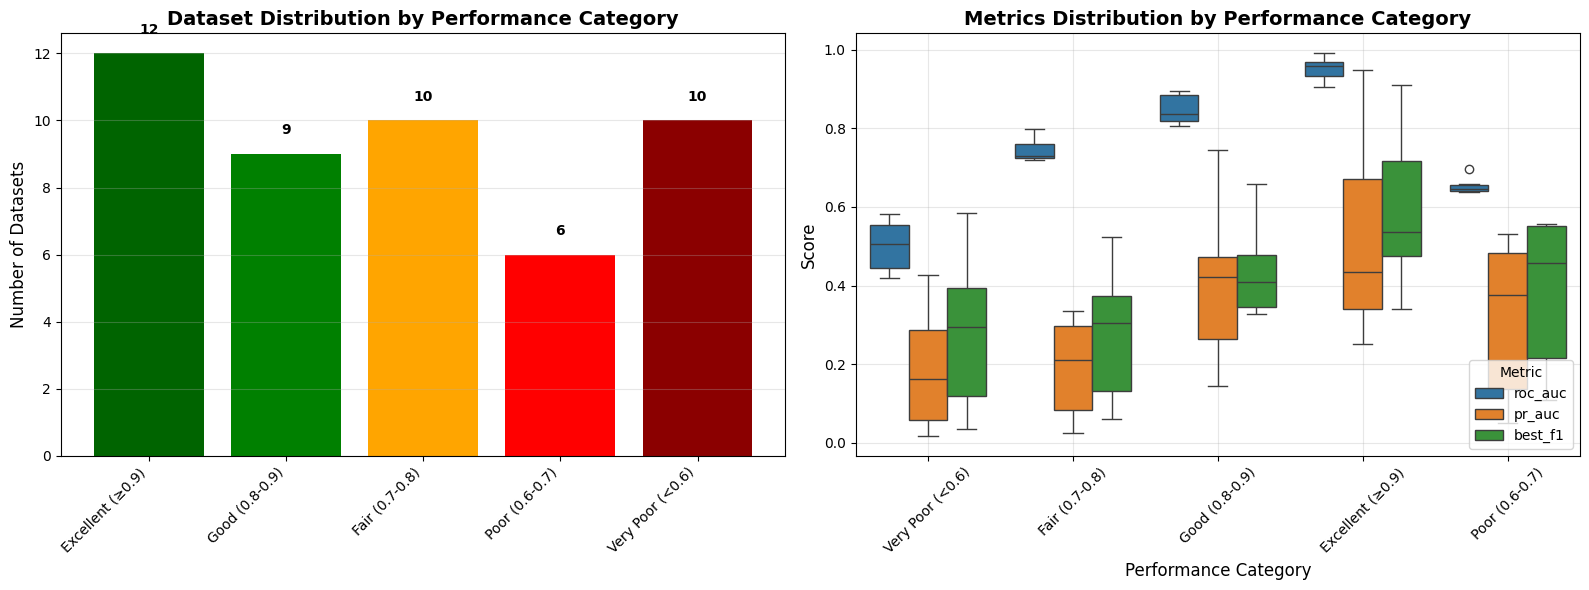


Performance Category Analysis

Excellent (≥0.9): 12 datasets
  Average ROC-AUC: 0.9526
  Average PR-AUC:  0.5175
  Average F1:      0.5900
  Avg Training Time: 258.56s
  Avg Epochs: 60.9
  Datasets: 4_breastw, 13_fraud, 16_http, 18_Ionosphere, 21_Lymphography, 31_satimage-2, 32_shuttle, 34_smtp, 38_thyroid, 40_vowels
    ... and 2 more

Good (0.8-0.9): 9 datasets
  Average ROC-AUC: 0.8512
  Average PR-AUC:  0.4113
  Average F1:      0.4407
  Avg Training Time: 311.09s
  Avg Epochs: 54.3
  Datasets: 3_backdoor, 11_donors, 20_letter, 22_magic.gamma, 23_mammography, 24_mnist, 25_musk, 27_PageBlocks, 37_Stamps

Fair (0.7-0.8): 10 datasets
  Average ROC-AUC: 0.7450
  Average PR-AUC:  0.1911
  Average F1:      0.2780
  Avg Training Time: 468.58s
  Avg Epochs: 56.3
  Datasets: 2_annthyroid, 5_campaign, 6_cardio, 8_celeba, 10_cover, 14_glass, 15_Hepatitis, 28_pendigits, 33_skin, 44_Wilt

Poor (0.6-0.7): 6 datasets
  Average ROC-AUC: 0.6541
  Average PR-AUC:  0.3175
  Average F1:      0.3827
 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

path = "/home/faried/Projects/nf4ad/results"
df = pd.read_csv(path + "/usflow_adbench_benchmark_results.csv")

# Create figure for training analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Training time distribution with box plot
axes[0].boxplot([df['training_time']], labels=['Training Time (s)'])
axes[0].set_ylabel('Seconds', fontsize=12)
axes[0].set_title('Training Time Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_yscale('log')

# Add statistics text
mean_time = df['training_time'].mean()
median_time = df['training_time'].median()
total_time = df['training_time'].sum()
axes[0].text(0.95, 0.95, 
             f'Mean: {mean_time:.2f}s\nMedian: {median_time:.2f}s\nTotal: {total_time/3600:.2f}h',
             transform=axes[0].transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=11)

# 2. Epochs distribution with box plot
axes[1].boxplot([df['n_epochs']], labels=['Epochs'])
axes[1].set_ylabel('Number of Epochs', fontsize=12)
axes[1].set_title('Early Stopping: Epochs Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add statistics text
mean_epochs = df['n_epochs'].mean()
median_epochs = df['n_epochs'].median()
axes[1].text(0.95, 0.95, 
             f'Mean: {mean_epochs:.1f}\nMedian: {median_epochs:.0f}\nMax: {df["n_epochs"].max()}\nMin: {df["n_epochs"].min()}',
             transform=axes[1].transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=11)

plt.tight_layout()
plt.savefig(path + '/usflow_benchmark_training_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*80)
print("Training Efficiency Summary")
print("="*80)
print(f"\nTotal training time: {total_time:.2f}s ({total_time/3600:.2f} hours)")
print(f"Average time per dataset: {mean_time:.2f}s")
print(f"Fastest training: {df['training_time'].min():.2f}s ({df.loc[df['training_time'].idxmin(), 'dataset']})")
print(f"Slowest training: {df['training_time'].max():.2f}s ({df.loc[df['training_time'].idxmax(), 'dataset']})")

print(f"\nEarly stopping effectiveness:")
print(f"Average epochs: {mean_epochs:.1f} (out of max 10000)")
print(f"Stopped early: {(df['n_epochs'] < 10000).sum()}/47 datasets ({(df['n_epochs'] < 10000).sum()/47*100:.1f}%)")
print(f"Minimum epochs: {df['n_epochs'].min()} ({df.loc[df['n_epochs'].idxmin(), 'dataset']})")
print(f"Maximum epochs: {df['n_epochs'].max()} ({df.loc[df['n_epochs'].idxmax(), 'dataset']})")